In [17]:
#Set global variables.
#epsilon = 0.0001 #tolerance to calculate collision time


def reflection_vector(x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma):
       
        wall_index = int(wall_index)
        vector_in = [omega0,xdot0,ydot0]
        
        #Find wall vector
        wall_x = table[wall_index][4]
        wall_y = table[wall_index][5]
        wall_dir = [wall_x, wall_y]
        
        #Create 90 deg clockwise rotation matrix to get normal
        rot_mat_clockwise_ninety = np.array([[cos(math.pi/2), sin(math.pi/2)],
                                 [-sin(math.pi/2), cos(math.pi/2)]])
        
        #Find the normal by rotating the wall clockwise 90 degrees
        normal = np.matmul(rot_mat_clockwise_ninety,wall_dir)
        
        #change normal to a 3D vector
        normal = np.append(normal, [0])
        #print(normal)
        
        #Find the angle between normal and y-axis
        theta = math.acos(np.dot(normal,[0,1,0]))
      
        
        #Find out how much anti-clockwise rotation is needed to align the normal with y-axis
        temp_num =  np.cross(normal, [0,1,0])[2]
        if temp_num < 0:                   
            theta = 2*math.pi-theta
        #print(theta)
        
        #Create anti-clockwise rotation matrix
        rot_mat = np.array([[-1,0,0],
                        [0,cos(theta), -sin(theta)],
                      [0,sin(theta), cos(theta)]])
        #print(rot_mat)
        
        #Create the reflection matrix 
        #gamma is the mass distribution, 0 for specular, non-zero for non-specular
        reflect_mat = np.array([[-(1-gamma**2)/(1+gamma**2), -2*gamma/(1+gamma**2),0],
                                [-2*gamma/(1+gamma**2),(1-gamma**2)/(1+gamma**2),0],
                               [0,0,-1]])
        #print(reflect_mat)

        #Find the reflection vector through matrix transformation
        vector_out = np.matmul(rot_mat,vector_in)
        vector_out_tangent = np.matmul(reflect_mat,vector_out)
        vector_out = np.matmul(np.transpose(rot_mat),vector_out_tangent)
        #vector_out = -1*vector_out
        #print(vector_out[1:])
        #print(normal[:2])
        
        #Find phase angle, phi
        phi = math.acos(np.dot(vector_out[1:],normal[:2]))
    
        #print(phi)
     
        #Return reflection vector along with phase angle.
        
        temp = np.append(vector_out,vector_out_tangent)
        return np.append(temp,phi)
    
def collision(x0,y0,omega0,xdot0,ydot0,nw,gamma):
    #Initialize collision output matrix.
    col_mat = []
    
    #Compute collision times for all walls.
    for i in range(nw):
        x1 = table[i][0]
        y1 = table[i][1]
        x2 = table[i][2]
        y2 = table[i][3]
        vx_wall = table[i][4]
        vy_wall = table[i][5]
        #Check for walls with undefined slope.
        #Tf there is one, find the collision point and wall index.
        if x1 == x2: 
            t = (x1-x0)/xdot0
            x = x1
            y = y0 + ydot0*t
            col_mat = np.append(col_mat,[x,y,t,i])
        #Check for walls that are parallel.    
        elif abs(np.cross([vx_wall,vy_wall], [xdot0,ydot0])) < epsilon:
            col_mat = np.append(col_mat,[100,100,-1,i])
        #Compute collision times for the remaining walls with defined slopes.  
        else:    
            m = slope(x1,y1,x2,y2)
            b = np.array([x0,y0,y1-m*x1])
            A = np.array([[1,0,-xdot0],
                [0,1,-ydot0],
                [-m,1,0]])
            A_inverse = np.linalg.inv(A) 
            col_mat = np.append(col_mat,np.append(np.matmul(A_inverse,b),[i])) 
    
    #Reshape the collision matrix for all alls
    col_mat = np.reshape(col_mat, (nw,4))
    #print("collision matrix")
    #print(col_mat)
    
    #Find the wall that the particle hits at minimum positive time.
    
    #min_time = min([n for n in col_mat[:,2]  if n > epsilon]) 
    #wall_index, min_index_column = np.where(col_mat == time)
    #col_output = np.array(col_mat[col_index_row,:])
    
    #General approach that works for any polygon
    #min_time = min([n for n in col_mat[:,2]  if n > epsilon])
    temp = []
    counter = 0
    for i in range(nw):
        ax = table[i][0]
        ay = table[i][1]
        bx = table[i][2]
        by = table[i][3]
        cx = col_mat[i][0]
        cy = col_mat[i][1]
        col_time = col_mat[i][2]

        if is_between(ax,ay,bx,by,cx,cy):
            temp = np.append(temp,col_mat[i,:],axis = 0)
            counter += 1
    #temp is the matrix with collision points that lie on the walls         
    temp = np.reshape(temp,(counter,4))
    #print(temp)
    
    #Find the minimum time out of the sorted walls
    min_time = min([n for n in temp[:,2]  if n > epsilon]) 
    
    #Find the row number for the minimum 
    row_number, column = np.where(temp == min_time)
    
    #Extract wall with minimum collision time and collision location.        
    col_output = temp[row_number,:]

    #Extract collision parameters
    x_col, y_col, t_col, wall_index = col_output[0,:]

    #Find the reflection vector and the phase angle phi, returns, vx_out,_vy_out, phi
    #print([x_col,y_col,xdot0,ydot0])
    vector_out = reflection_vector(x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma)
    #print("vector_out")
    #print(vector_out)
    
    #Find the parameterized length of collision point and add it to the output
    s = parametrized_length(x_col,y_col,wall_index,nw) 
    
    #Append parametrized length, vector out, and phase angle to collision output
    col_output = np.append(col_output,s)
    col_output = np.append(col_output,vector_out)    
    
    return np.asarray(col_output)


#this functions runs the simulation and outputs a matrix vector 
def polygon_sim(x0,y0,omega0,xdot0,ydot0,count,gamma):
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])
    
    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        #plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0
    
    #Find the parameters after collision
    while n < count:
        c = collision(x0,y0,omega0,xdot0,ydot0,nw,gamma)
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        #plt.plot([x0,xtemp], [y0,ytemp], 'k-', lw=0.25) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (n,7))
    
    #Set figure size
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(6, 6)
    
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    return np.array(output)

In [18]:
from __future__ import print_function
from pylab import *
import math
import numpy as np
import matplotlib.pyplot as plt


#Set global variables.
epsilon = 0.0001 #tolerance to calculate collision time
#gamma = 0.2
omega = 1
#gamma = 1/math.sqrt(2)

#Create two arrays with x and y coordinates of vertices of the table here.
#Always have the coordinates ordered in clockwise direction
def create_table(x,y):
    
    #table_shape = figure(1)
    #Throw exceptions if there aren't enough vertices or if the arrays with x and y coordiantes don't have same length.
    if len(x) < 3:
        raise Exception('Error: You need at least three sets of points of build the table.')
    elif len(x) != len(y):
        raise Exception('Error: The array with x and y coordinates are of different length.')
        
    #Find the number of vertices.     
    nw = len(x)
    
    #Set curve type for each wall MANUALLY;  1 for line, 0 for circle.
    curve_type = [1]*nw
    
    #Set collision type for each wall MANUALLY;  0 for specular/smooth, 1 for rough/spin.
    collision_type = [0]*nw 
    
    #Initialize the table.
    table =  []
    
    #Build the walls.
    for i in range(nw):
        x0,y0 = x[i], y[i]
        
        #When at the final vertex, next coordinate needs to be the initial vertex.
        if i ==  nw-1:
            i = -1
            
        #Find the parameters for each wall.    
        x1,y1 = x[i+1], y[i+1]
        mag = ((x1-x0)**2 + (y1-y0)**2)**0.5
        xdot0, ydot0 = (x1-x0)/mag,(y1-y0)/mag
        
        #Plot the particular wall.
        #plt.plot([x0,x1], [y0,y1], 'k-', lw=2)
        
        
        
        #Append the walls to the table one by one.
        table = np.append(table, [x0,y0,x1,y1,xdot0, ydot0, curve_type[i], collision_type[i]])
    
    #set axes limits
    #plt.xlim(0,x[1]*0.9)
    #Reshape the table to correct dimensions.   
    table = np.reshape(table, (nw,8))
    
    return np.asarray(table)    


def create_wedge(theta,r):
    x0 = 0
    y0 = 0
    x1 = r*cos(theta/2)
    y1 = r*sin(theta/2)
    x2 = r*cos(theta/2)
    y2 = -r*sin(theta/2)
    
    return create_table([x0,x1,x2],[y0,y1,y2])
    
    
table = create_wedge(math.pi/3,40)

#Calculate the slope for a given pair of points.
def slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1) 

#Calculate the distance between any two points
def distance(x1,y1,x2,y2):
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

#Determine if a point lies between two points
def is_between(ax,ay,bx,by,cx,cy):
    return -epsilon < (distance(ax,ay,cx,cy) + distance(cx,cy,bx,by) - distance(ax,ay,bx,by)) < epsilon

#Find the parametrized length at the collision point
def parametrized_length(x_col,y_col,wall_index,nw):
    table_length = 0
    col_length = 0
    for i in range(nw):
        x1 = table[i][0]
        y1 = table[i][1]
        x2 = table[i][2]
        y2 = table[i][3]
        
        #Find the table length by adding each wall
        table_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
        
        #Find wall length up to the collision point
        if i < wall_index:
            col_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
        #Add the right fraction of the final wall
        if i == wall_index:
            col_length += ((x_col-x1)**2 + (y_col-y1)**2)**0.5
    
    #Parametrize s as a fraction of total table length.
    s = col_length/table_length
    
    return s



In [7]:
from pylab import *
import math
import numpy as np

# tolerance
epsilon = 0.000001

# range of gamma values to sample
# you can increase this range beyond 1 

delta = 0.00001
gamma_range = np.arange(0,1.1,delta)

#estimate gamma value that gives orbit of period n 
def gamma_periodic_numerical(n, phi):
    wedge_angle  = 2*phi
    pp_gamma = []
    min_error = []
    error = np.array([None]*len(gamma_range))
    for i in range(len(gamma_range)):
        gamma =gamma_range[i]
        #print(gamma)
        T_gamma = np.array([[-(1-gamma**2)/(1+gamma**2), -2*gamma/(1+gamma**2),0],
                                    [-2*gamma/(1+gamma**2),(1-gamma**2)/(1+gamma**2),0],
                                   [0,0,-1]])
        theta = -(math.pi-wedge_angle)
        identity = np.array([[1,0,0],
                           [0,1,0],
                           [0,0,1]])
        state = identity
        #run the simulation for this particular gamma
        col_count = 0
        while col_count < n:
            state = new_state(state,theta,gamma)
            theta = -theta;
            col_count += 1   
            
        error[i] =  find_error(state)
        #print(error[i])
    
    
#     plt.plot(gamma_range, error, 'b-')
#     plt.xlabel('$\gamma$')
#     plt.ylabel('rss')
#     plt.show()
    
    for i in range(1,len(gamma_range)-1,1):
        #print(error1)
        if error[i-1] > error[i] and error[i+1] > error[i]:
            min_error = np.append(min_error, error[i])
            pp_gamma = np.append(pp_gamma, gamma_range[i])
            
    return pp_gamma
            
# error is the residual sum of squares between the transformation in the nth step and identity matrix    
def rotation(theta):
    return np.array([[1,0,0],
                        [0,cos(theta), -sin(theta)],
                        [0,sin(theta), cos(theta)]])
def reflection(gamma):
    return np.array([[-(1-gamma**2)/(1+gamma**2), -2*gamma/(1+gamma**2),0],
                                    [-2*gamma/(1+gamma**2),(1-gamma**2)/(1+gamma**2),0],
                                   [0,0,-1]])

def new_state(current_state, theta, gamma):
    T_gamma = reflection(gamma)
    R_theta = rotation(theta)
    return np.matmul(np.matmul(R_theta, T_gamma), current_state) 
            
        

def find_error(x):
    error = 0 
    for i in range(3):
        for j in range(3):
            if i == j: 
                error += (x[i][j]-1)**2 
            else:
                error += x[i][j]**2
    return error

#gamma_periodic_numerical(8,np.random.uniform(0,math.pi/2))

0
4


<IPython.core.display.Javascript object>


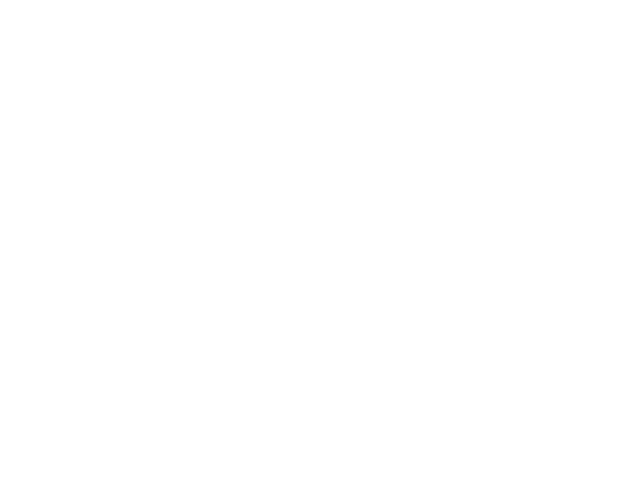

<IPython.core.display.Javascript object>


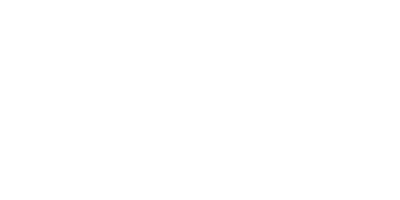

6
8
10
12
14
16
18
20
1
4
6
8
10
12
14
16
18
20
2
4
6
8
10
12
14
16
18
20


KeyboardInterrupt: 

In [21]:
%matplotlib notebook

import os
folderName = 'test'
epsilon = 1e-3



def polygon_sim_sampling(x0,y0,omega0,xdot0,ydot0,count,gamma,phi):
    #billiard table figure  
    plt.clf()
    billiard_table = figure(4)
   
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])
    
    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        billiard_table,plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0
    
    #Find the parameters after collision
    while n < count:
        c = collision(x0,y0,omega0,xdot0,ydot0,nw,gamma)  
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        billiard_table, plt.plot([x0,xtemp], [y0,ytemp], 'b-', lw=0.5) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (-1,7))
    #period = find_period(output)
    #print(period)
     
   
    plt.title('Wedge with $\phi$ = %1.3f and $\gamma$ = %1.4f'%(phi, gamma), y=0.95)
    billiard_table.set_size_inches(4, 2)
    plt.xlim([0,100])
    plt.show()
    plt.axis('equal')
    plt.axis('off')
    plt.savefig(os.path.join(folderName, str(gamma)) + '.eps', format='eps', dpi = 600)
    return
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    #return np.array(output)

#at least 101 collisions required to find out if there is a period less than or equal to hundred    
def find_period(output):
    l = len(output[:,0])
    #print(l)
    period = -1

    for i in range(2,l):  
        difference =((output[i,5] - output[1,5])**2+(output[i,6] - output[1,6])**2)**0.5
        #print(difference)
            
        if difference < epsilon:
            period = i-1
            break         

    return period    


import random
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


viridis = cm.get_cmap('viridis', 8)


#collision count
count = 100  

#largest orbit N
N = 20

for i in range(10):    
    print(i)
    for j in range(4,N+2,2):
        print(j)
        phi = np.random.uniform(0,math.pi/2.0)
        pp_gamma = gamma_periodic_numerical(j,phi) 
        x0 = 50
        y0 = 0
        theta_random = np.random.uniform(0.4*pi, 0.6*pi)   
        omega0 = np.random.uniform(-1,1)
        xdot0 = math.cos(theta_random)
        ydot0 = math.sin(theta_random)  

        table = create_wedge(2*phi,250)
        if len(pp_gamma) != 0:
            gamma = random.choice(pp_gamma)
            polygon_sim_sampling(x0,y0,omega0,xdot0,ydot0,count,gamma,phi)
        else:
            continue

    

0
3


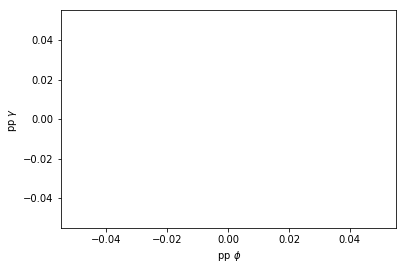

4


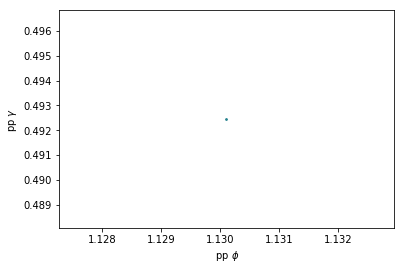

5


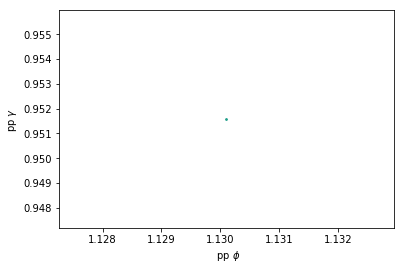

1
3


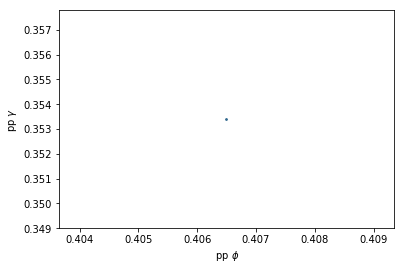

4


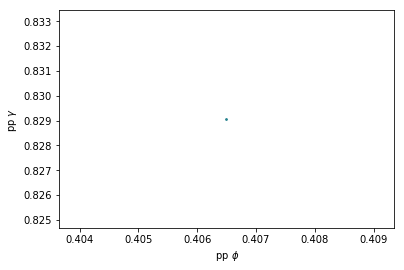

5


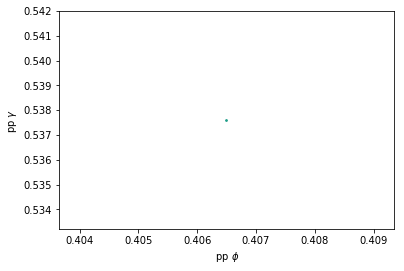

2
3


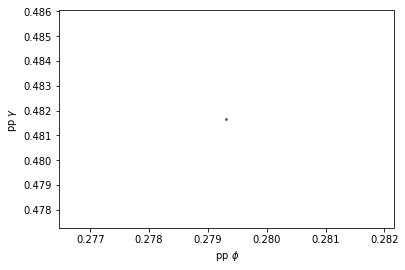

4


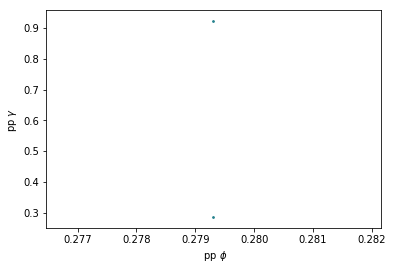

5


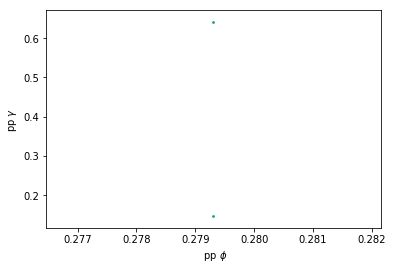

3
3


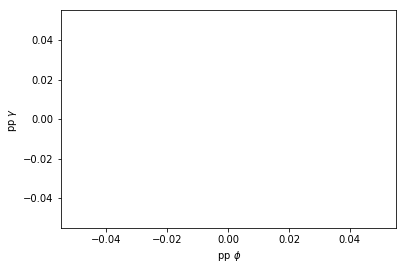

4


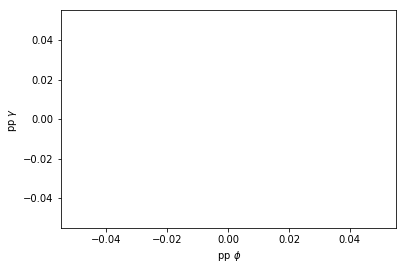

5


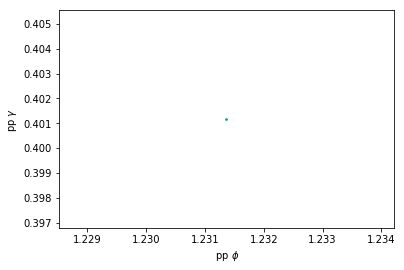

4
3


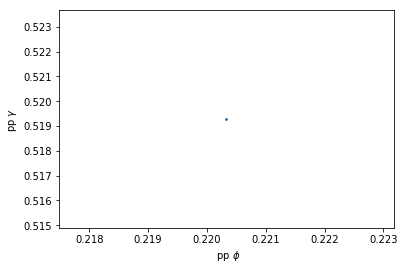

4


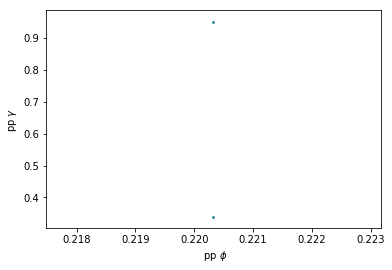

5


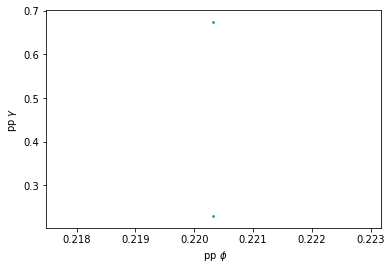

5
3


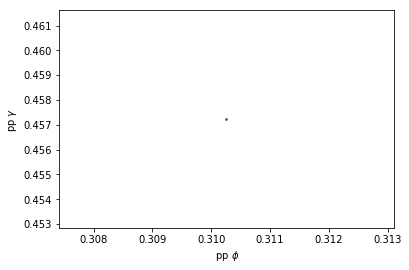

4


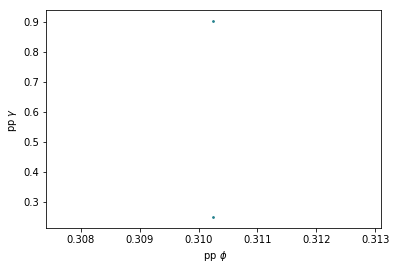

5


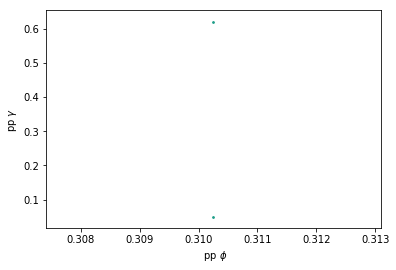

6
3


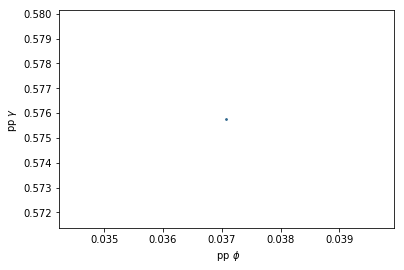

4


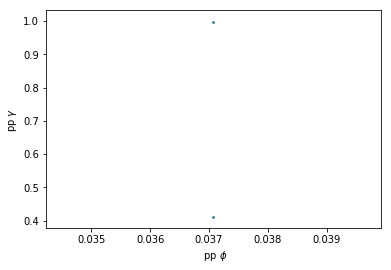

5


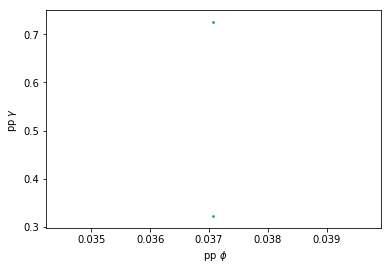

7
3


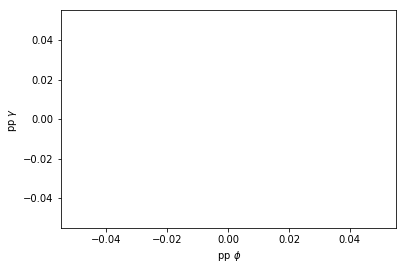

4


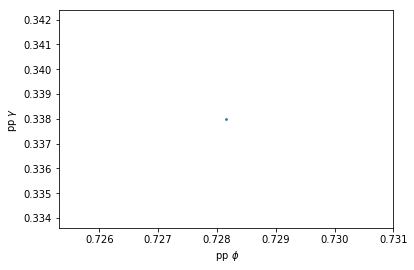

5


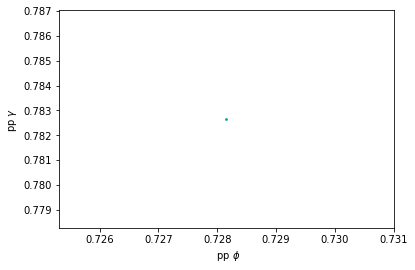

8
3


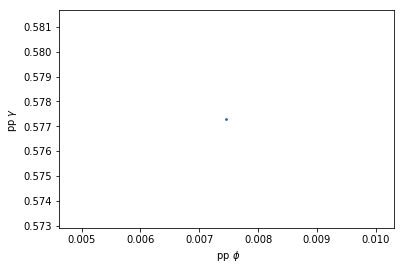

4


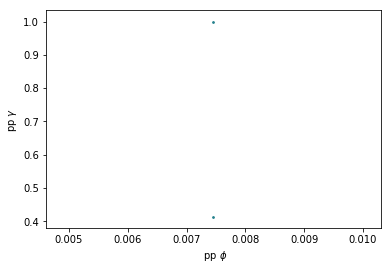

5


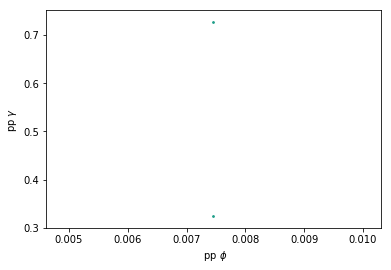

9
3


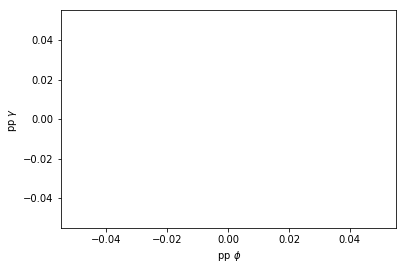

4


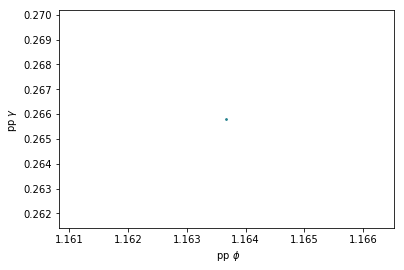

5


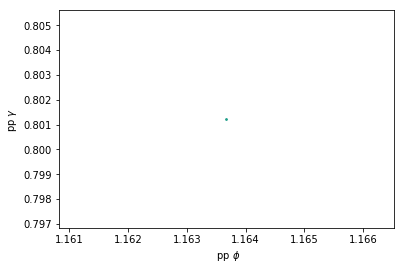

10
3


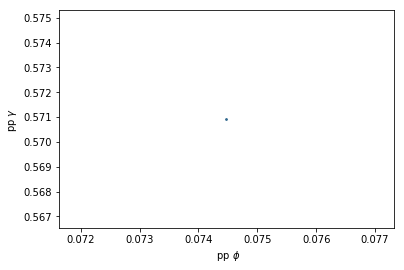

4


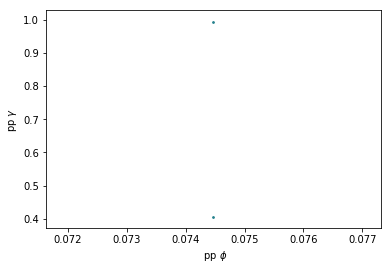

5


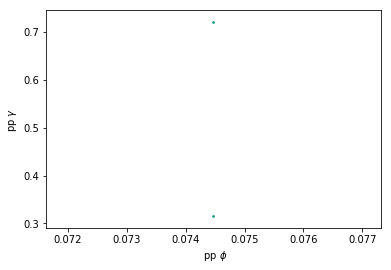

11
3


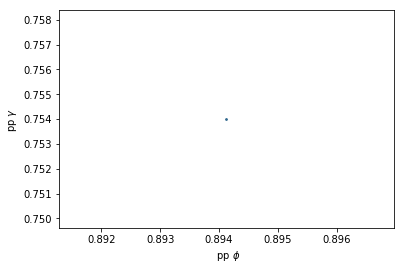

4


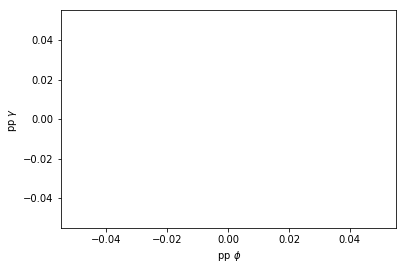

5


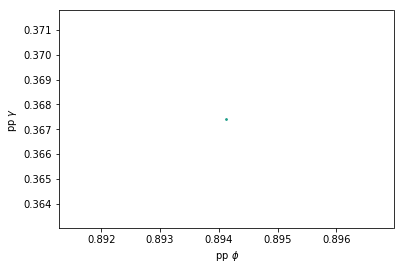

12
3


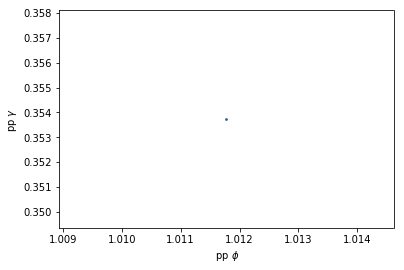

4


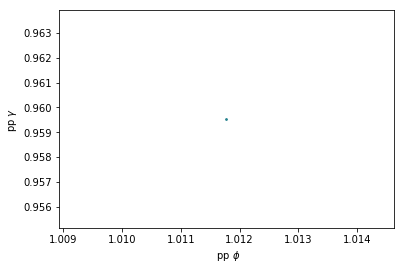

5


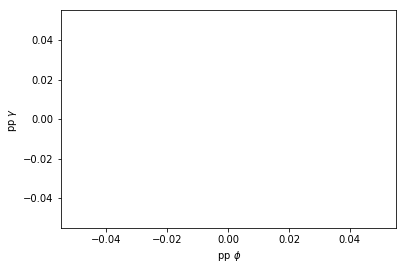

13
3


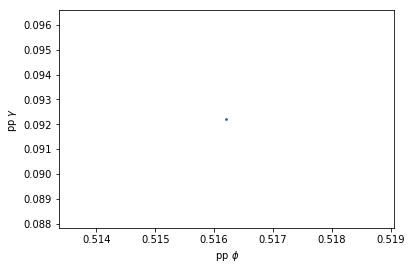

4


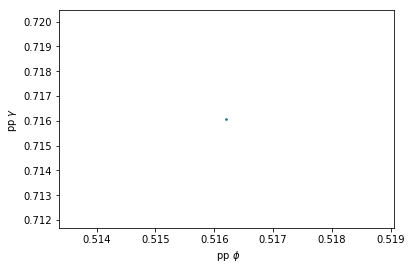

5


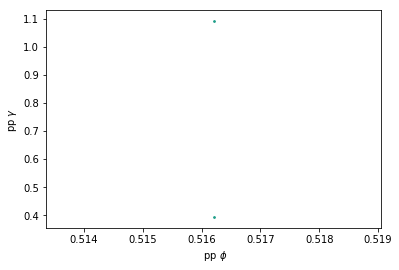

14
3


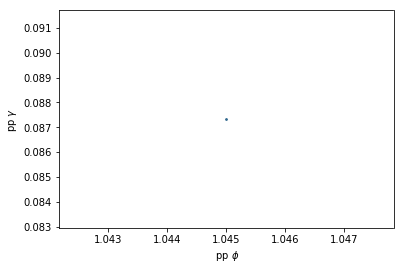

4


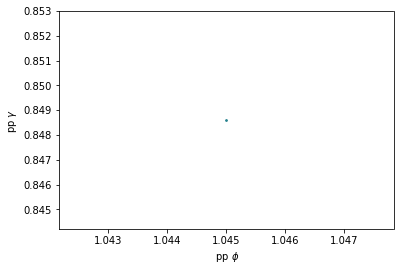

5


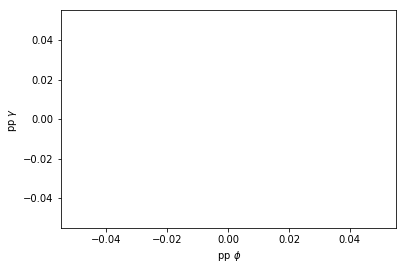

15
3


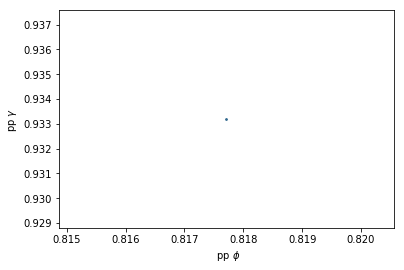

4


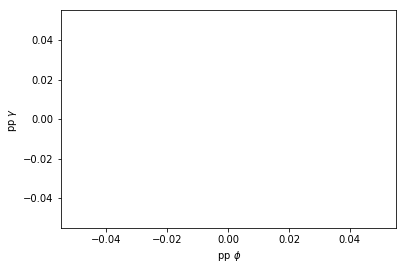

5


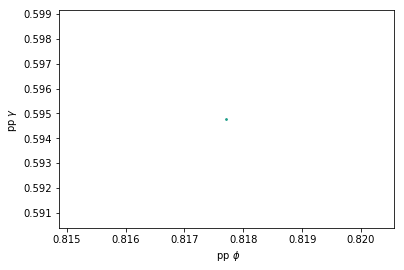

16
3


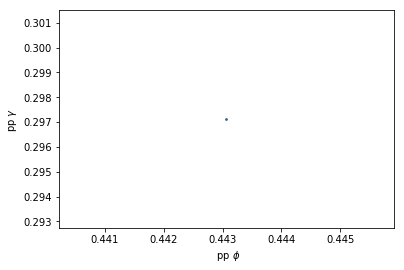

4


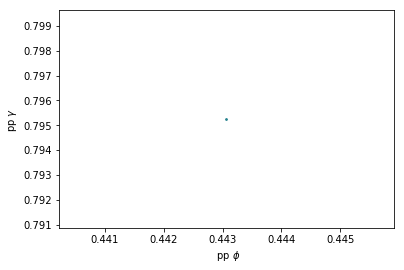

5


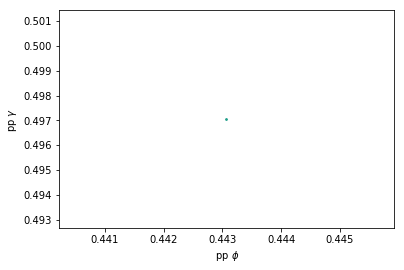

17
3


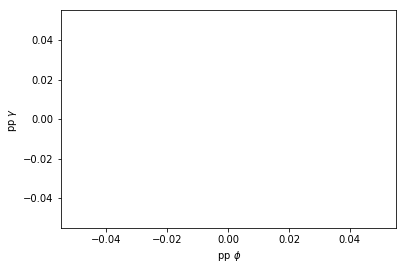

4


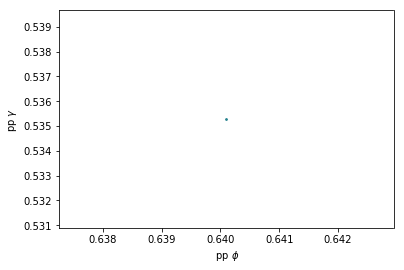

5


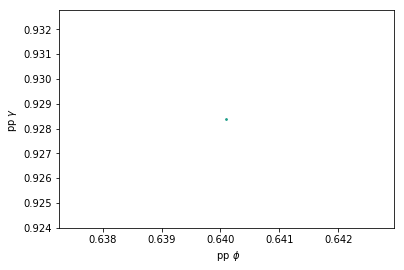

18
3


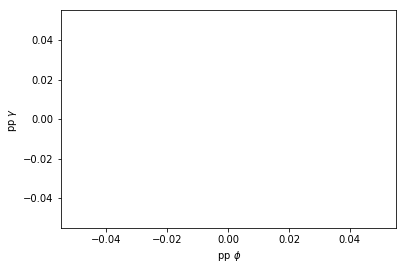

4


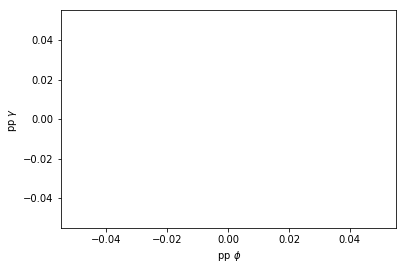

5


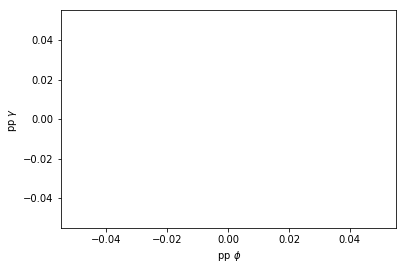

19
3


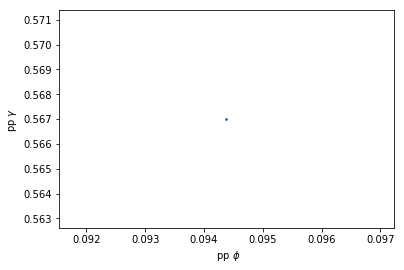

4


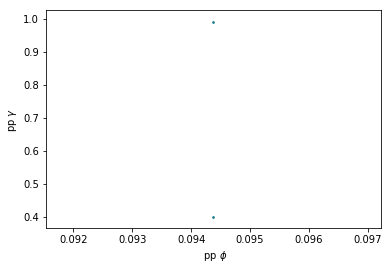

5


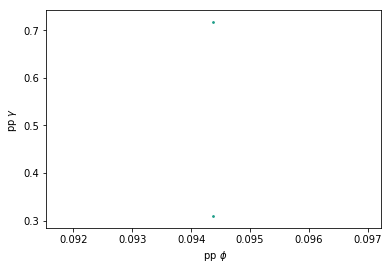

In [22]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#largest orbit is 2n-2 with smallest starting at 6
n = 5


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 10))
newcmp = ListedColormap(newcolors)

for i in range(20):
    print(i)
    phi = np.random.uniform(0,math.pi/2)
    for j in range(3,n+1,1):
        print(j)
        pp_gamma = gamma_periodic_numerical(2*j,phi) 
        plt.scatter(np.ones(len(pp_gamma))*phi,pp_gamma,s = 3, color=newcolors[j][:])
        plt.xlabel(' pp $\phi$')
        plt.ylabel('pp $\gamma$')
        


In [18]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#largest orbit N
N = 20


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 10))


[[0.267004 0.004874 0.329415 1.      ]
 [0.281412 0.155834 0.469201 1.      ]
 [0.244972 0.287675 0.53726  1.      ]
 [0.190631 0.407061 0.556089 1.      ]
 [0.147607 0.511733 0.557049 1.      ]
 [0.119699 0.61849  0.536347 1.      ]
 [0.20803  0.718701 0.472873 1.      ]
 [0.430983 0.808473 0.346476 1.      ]
 [0.709898 0.868751 0.169257 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
